<a href="https://colab.research.google.com/github/AlexandraLJones/FIRE-CloudComputing/blob/main/The_Deliverables_Draft_FIRE198WrittenReport.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#FIRE 198 Final Report 
##Convective Core Statistics
###[Diego Pantelis, Ethan Pak, Yasmine Torres, Sam Kinloch]
###[5/10/2021]


#Introduction


**About Convective Cores**

Convective Cores play a major role in convective heating and moisture transport, which are fundamental processses in atmospheric convection. In this project, the core statistics are only calculated for the convective updraft cores, meaning all of the velocity values are positive.

**Our Goal**

For this project, our goal was to create working models that displayed the core statistics of the convective updrafts, similar to that of the models in Khairoutdinov et al (2009). To accomplish this task, we had to devise a plan for indexing the statistics for both approaches. Additionally, both objectives used Numpy functions to calculate the statistics, but the applications slightly varied. For Objective 1, we mimicked plane transecting through the cores, like in Khairoutdinov et al. For Objective 2, we identified each core as a 2D object, which allowed us to utilize the watershedding algorithm. After creating the scatter plots, we needed to compare our plots to Figure 8 in Khairoutdinov et al (2009), as well as comparing the plots from both objectives.

**Motivation**

Our solution to this deliverable would allow us to further analyze the convective cores dataset and allow other researchers in our stream to have a better understanding of the data in the convective cores data set. The authors of the scholarly article produced similar graphs to show downdraft and updraft core statistics. In our deliverable we show similar scatter plots. Additionally, this same solution could be applied to the convective downdrafts and show similar plots to Figure 9 in Khairoutdinov et al (2009). Another source of motivation is to determine how applying different methods/algorithms may result in different looking statistics, even though they are applied to the exact same dataset.

#Dependencies





The following external tools are needed to be installed and loaded for the code to work. 

In [ ]:
#load needed packages
from google.colab import drive #this is how we access data stored on our drive
import numpy as np # we need the numPy package to  do transformations on our data as multidimensional arrays
from numpy import ma # for masking the array
import cv2 # this package is for computer vision
import skimage #image processing package
from skimage.feature import peak_local_max #grab this method specifically so we can use it more easily
from scipy import ndimage as ndi #an extension of numPy it has more specialed methods for scientific applications
import matplotlib.pyplot as plt # so we can visualize the steps along the way
import matplotlib.patches as mpatches #to be able to add a legend to the graphs
from google.colab.patches import cv2_imshow #we need the image visualizer specific to google colab
drive.mount('/content/gdrive') #this comand is how we tell google we have permission to access the data on drive

Mounted at /content/gdrive


#Data

**Source**

The data used for this project was sourced from the GCE (Goddard Cumulus Ensemble) model (Tao et al., 2003). The data was provided to us in the FIRE-CC shared drive as numpy arrays. We were provided four arrays. The  ``` w_4d ``` array is a four dimensional array in which the first dimension is time and the last 3 dimensions are height, y direction, and x direction. This gives us several timesteps with a region in space for each. The units for each point in space of the 4d array are meters per second (m/s). The arrays ``` xdir, ydir, height ``` are single dimension distances measured in kilometers (km).

In [ ]:
#load convective cores data numpy arrays from files in the FIRE-CC shared drive
w_4d=np.load("/content/gdrive/Shared drives/FIRE-CC/convective cores/test_data/w_4D.npy")
xdir=np.load("/content/gdrive/Shared drives/FIRE-CC/convective cores/test_data/xdir.npy")
ydir=np.load("/content/gdrive/Shared drives/FIRE-CC/convective cores/test_data/ydir.npy")
height=np.load("/content/gdrive/Shared drives/FIRE-CC/convective cores/test_data/height.npy")

**Goals**

Our goals in regards to the data were to first make sure that all the data points we were dealing with were in fact considered convective cores. In order to ensure this we masked all voxels that were less than or equal to 1 m/s.

In [ ]:
#Mask any voxel that is <=1 m/s
masked_4d = np.ma.masked_where(w_4d<=1, w_4d)

print(masked_4d)

[[[[-- -- -- ... -- -- --]
   [-- -- -- ... -- -- --]
   [-- -- -- ... -- -- --]
   ...
   [-- -- -- ... -- -- --]
   [-- -- -- ... -- -- --]
   [-- -- -- ... -- -- --]]

  [[-- -- -- ... -- -- --]
   [-- -- -- ... -- -- --]
   [-- -- -- ... -- -- --]
   ...
   [-- -- -- ... -- -- --]
   [-- -- -- ... -- -- --]
   [-- -- -- ... -- -- --]]

  [[-- -- -- ... -- -- --]
   [-- -- -- ... -- -- --]
   [-- -- -- ... -- -- --]
   ...
   [-- -- -- ... -- -- --]
   [-- -- -- ... -- -- --]
   [-- -- -- ... -- -- --]]

  ...

  [[-- -- -- ... -- -- --]
   [-- -- -- ... -- -- --]
   [-- -- -- ... -- -- --]
   ...
   [-- -- -- ... -- -- --]
   [-- -- -- ... -- -- --]
   [-- -- -- ... -- -- --]]

  [[-- -- -- ... -- -- --]
   [-- -- -- ... -- -- --]
   [-- -- -- ... -- -- --]
   ...
   [-- -- -- ... -- -- --]
   [-- -- -- ... -- -- --]
   [-- -- -- ... -- -- --]]

  [[-- -- -- ... -- -- --]
   [-- -- -- ... -- -- --]
   [-- -- -- ... -- -- --]
   ...
   [-- -- -- ... -- -- --]
   [-- -- -- ... -- -- 

The data now consists of only points which are considered convective cores (>1m/s) and masked data points (represented by dashes). Our data was now ready to be iterated through using the ```notmasked_contiguous()``` function, allowing us to find slices of not masked data to perform calculations upon. This iteration and calculation method is further elaborated upon in the 'methods' section.


#Methods





##Objective 1

**Masking**

The first thing that we needed to do for Objective 1 was to mask all of the data less than 1 so we are only looking at the updraft cores. We decided to do this by using the `np.ma.masked_where()` call to mask any voxels that were within w_4d and less than or equal to one.

In [ ]:
#Mask any voxel that is <=1 m/s
masked_4d = np.ma.masked_where(w_4d<=1, w_4d)

**Data at Vertical Slice**

The next part of our objective was to calulate the Maximum Velocity, Average Velocity, and Size at each vertical slice. Because we were slicing a 4D array we knew that we would need to have a 3D array as our result for each. We started by creating a list for all three values to use as our outer list.

In [ ]:
#Creation of arrays (outer arrays)
size = []
maximum_velocity = []
average_velocity = []

We then knew that we needed to loop through the `masked_4d` array. The first level is time which has 12 steps so we put the first for loop in range 12. We then created an inner array for each value that will be appended to the result array every time step. The next level of the array is height which has 43 values so we needed a for loop in range 43. The first thing that we did in this layer was to create another set of arrays to be the third dimension in our result array. We then created `slices` which were the not masked contiguous results at that time and height_axis. we then nested 2 more for loops. The first was the length of slices and the next was the length of slices at i. We then created a temporary variable to hold the data at the current time and height step named `temp`. The next thing that we did was to append the calculated values to the height array. We calculated the values using `np.amax` for max velocity, `np.mean` for average velocity, and `len()` for size. We then appended the height arrays to the time arrays in the `height axis` loop and then appended the height array to the final array in the time loop.

In [ ]:
#For each time step
for time in range(12):
  
  #Creation of first dimension (Time step)

  maximum_velocity_t = []
  average_velocity_t = []
  size_t = []


  #For each height step
  for height_axis in range(43):
    
    #Creation of second dimension (Height step)

    maximum_velocity_h = []
    average_velocity_h = []
    size_h = []



    #slices is the not masked data that we will need to iterate through
    slices = ma.notmasked_contiguous(masked_4d[time,height_axis,:,:],0)


    #For each width step
    for i in range(len(slices)) :
      for j in range(len(slices[i])) :

        #Creation of third dimension (width step), this is where the average 
        #and maximum velocities are calculated and appended to the third dimension


        #Calculation of size as well as max and average velocities
        temp = masked_4d.data[time,height_axis,:,:]

        #Append calculated values at each height step
        maximum_velocity_h.append(np.amax(temp[slices[i][j],0]))           
        average_velocity_h.append(np.mean(temp[slices[i][j],0]))
        size_h.append(len(temp[slices[i][j],0]))


    #Append arrays at each height for that time step

    maximum_velocity_t.append(maximum_velocity_h)           
    average_velocity_t.append(average_velocity_h)
    size_t.append(size_h)

  #Append arrays at each time step into first array (outer array)

  maximum_velocity.append(maximum_velocity_t)           
  average_velocity.append(average_velocity_t)
  size.append(size_t)

  #End up with a 3D array [time, height, width], where each value represents whatever is being calculated(Avg or max velocity, or size)

**Percentiles**

We begin by taking our lists of values that have been computed above and converting them into arrays. We also create outer arrays which our percentile values will be appended into.

In [ ]:
#Convert list (maximum_velocity) into array
max_vel = np.array(maximum_velocity)

#Creation of outer array for maximum velocity

max_vel_50 = []
max_vel_90 = []
max_vel_99 = []

#Convert list (average_velocity) into array
avg_vel = np.array(average_velocity)

#Creation of outer array for average velocity

avg_vel_50 = []
avg_vel_90 = []
avg_vel_99 = []

#Creation of outer array for size

size_50 = []
size_90 = []
size_99 = []

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  # This is added back by InteractiveShellApp.init_path()


Then we loop through each height in each time step in order to find the 50th, 90th, and 99th percentile of each value at those steps. We used the function np.nanpercentile() in order to ignore any nan values within our arrays.

In [ ]:
#This loop goes through the time step dimension of our previous arrays
for i in range(12):

  #Creation of first dimension for percentile arrays
  max_vel_50_t = []
  max_vel_90_t = []
  max_vel_99_t = []
  avg_vel_50_t = []
  avg_vel_90_t = []
  avg_vel_99_t = []
  size_50_t = []
  size_90_t = []
  size_99_t = []

  #This loop goes through the height step dimension at each time step of our previous arrays
  for j in range(43):

    #Since we don't have a loop for width, our percentile functions will take the percentile of all the widths
    #np.nanpercentile() allows us to find the percentile while ignoring the nan values

    #these are the 50th, 90th, and 99th percentiles for max vertical velocity
    max_vel_50_t.append(np.nanpercentile(max_vel[i][j], 50))
    max_vel_90_t.append(np.nanpercentile(max_vel[i][j], 90))
    max_vel_99_t.append(np.nanpercentile(max_vel[i][j], 99))

    #these are the 50th, 90th, and 99th percentiles for average vertical velocity
    avg_vel_50_t.append(np.nanpercentile(avg_vel[i][j], 50))
    avg_vel_90_t.append(np.nanpercentile(avg_vel[i][j], 90))
    avg_vel_99_t.append(np.nanpercentile(avg_vel[i][j], 99))

    ##these are the 50th, 90th, and 99th percentiles for size
    size_50_t.append(np.nanpercentile(size[i][j], 50))
    size_90_t.append(np.nanpercentile(size[i][j], 90))
    size_99_t.append(np.nanpercentile(size[i][j], 99)) 

  #Append the percentiles for all the widths, at each height step, at each time step, to the outer arrays
  max_vel_50.append(max_vel_50_t)
  max_vel_90.append(max_vel_90_t)
  max_vel_99.append(max_vel_99_t)
  avg_vel_50.append(avg_vel_50_t)
  avg_vel_90.append(avg_vel_90_t)
  avg_vel_99.append(avg_vel_99_t)  
  size_50.append(size_50_t)
  size_90.append(size_90_t)
  size_99.append(size_99_t)

/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1366: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


 At the end of this iteration cycle we are left with 9 [12, 43] arrays ([time, height]), thus giving us the percentiles at each height for each time. The first three are the 50th, 90th, and 99th percentiles for maximum velocity, the next three are the 50th, 90th, and 99th for average velocity, and the last three are the 50th, 90th, and 99th for size. These arrays are then used to create scatter plots.

**Plotting**

Our plots are created by looping through each time step and plotting all of the percentiles for that time step, using the height of the percentile as the y-axis. 50th percentile points are in blue. 90th percentile points are in green. 99th percentile points are in red.

Graph for maximum velocity

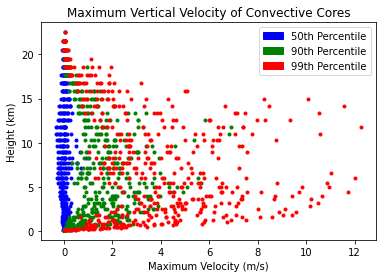

In [ ]:
#Maximum vertical velocities

#50th percentile
for x in range(12) :
  plt.scatter(max_vel_50[x], height, marker='.', color = 'b')

#90th percentile
for x in range(12) :
  plt.scatter(max_vel_90[x], height, marker='.', color = 'g')

#99th percentile
for x in range(12) :
  plt.scatter(max_vel_99[x], height, marker='.', color = 'r')

#Creation of plot
plt.title('Maximum Vertical Velocity of Convective Cores')
plt.ylabel("Height (km)")
plt.xlabel('Maximum Velocity (m/s)')
fifty_color = mpatches.Patch(color = 'b', label = '50th Percentile')
ninety_color = mpatches.Patch(color = 'g', label = '90th Percentile')
ninetynine_color = mpatches.Patch(color = 'r', label = '99th Percentile')
plt.legend(handles = [fifty_color, ninety_color,ninetynine_color])
plt.show()

This graph shows that the convective cores with the maximum vertical velocity tend to be in the range from 2-16 km high. At the maximum height the velocity is pretty low. The 50th percentile has a very low maximum velocity. The 90th and 99th percentile have much higher velocities with the 90th percentile reaching to around 6m/s and the 99th percentile reaces as far as 12m/s

Graph for average velocity

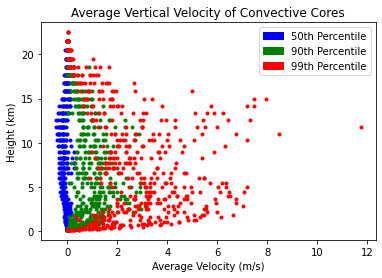

In [ ]:
#Average vertical velocities

#50th percentile
for x in range(12) :
  plt.scatter(avg_vel_50[x], height, marker='.', color = 'b')

#90th percentile
for x in range(12) :
  plt.scatter(avg_vel_90[x], height, marker='.', color = 'g')

#99th percentile
for x in range(12) :
  plt.scatter(avg_vel_99[x], height, marker='.', color = 'r')

#Creation of plot
plt.title('Average Vertical Velocity of Convective Cores')
plt.ylabel("Height (km)")
plt.xlabel('Average Velocity (m/s)')
fifty_color = mpatches.Patch(color = 'b', label = '50th Percentile')
ninety_color = mpatches.Patch(color = 'g', label = '90th Percentile')
ninetynine_color = mpatches.Patch(color = 'r', label = '99th Percentile')
plt.legend(handles = [fifty_color, ninety_color,ninetynine_color])
plt.show()

The graph for average velocity shows an almost identical height distribution with most values being from 2-16km high. While the 50th percentile is still around 0, the 90th and 99th are slightly changed. The 90th percentile for average velocity only reaches around 3m/s and the 99th only goes to around a max of 8m/s. There is one outlier in the 99th percentile that does reach 12m/s, however.

Graph for the size

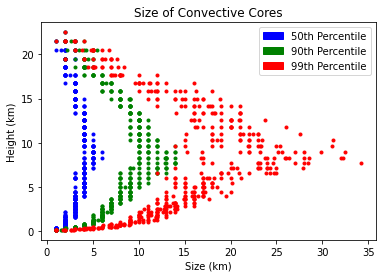

In [ ]:
#Size

#50th percentile
for x in range(12) :
  plt.scatter(size_50[x], height, marker='.', color = 'b')

#90th percentile
for x in range(12) :
  plt.scatter(size_90[x], height, marker='.', color = 'g')

#99th percentile
for x in range(12) :
  plt.scatter(size_99[x], height, marker='.', color = 'r')

#Creation of plot
plt.title('Size of Convective Cores')
plt.ylabel("Height (km)")
plt.xlabel('Size (km)')
fifty_color = mpatches.Patch(color = 'b', label = '50th Percentile')
ninety_color = mpatches.Patch(color = 'g', label = '90th Percentile')
ninetynine_color = mpatches.Patch(color = 'r', label = '99th Percentile')
plt.legend(handles = [fifty_color, ninety_color,ninetynine_color])
plt.show()

The size graph shows data that is different than the other two. For this graph there is a clear difference between the data gathered at each percentile. This data also shows much more of a precise location where the maximum size is located. At around 10km high there is the maximum size of the convective cores. The size of the 50th percentile goes to around 5km, the 90th percentile goes to around 15km, and the 99th percentile goes to 35km.

##Objective 2: Watershed Image Segmentation Algorithm

**Lists**

First, lists must be created to store the forthcoming data inside nested lists.After performing the watershed algorithm the data will be stored in the following variables for size, maximum velocity, and average velocity. Due to the nature of the data, the originally 4D data will be stored as 3D data because we are looking at the horizontal cross sections for each time and height step.

In [ ]:
ws_core_size = [] # size data
ws_core_vel_max = [] # max velocity data
ws_core_vel_avg = [] # average velocity data

**Watershedding**

The next step was to perform the watershedding algorithm on the w_4d dataset. The nature of the watershedding algorithm requires 2D data, so the originally 4D data is sliced at each time and height step into 2D data. Two loops are used to iterate over each time and height step. The first step to begin the watershedding algorithm is masking the data and filling the masked data, and then storing each as separate variables. Next, the data becomes normalized using cv2.normalize() which uses the masked data that was filled. Then, the local max is found using peak_local_max on the normalized data, and the markers are also found. Lastly, the watershedding algorithm is called using the normalized data and the markers as parameters. Now that the watershedding is done for that time and height step, the statistics must be calculated for each individual core of that specific slice. Each core statistic is added to its respective nested list, and each run of the loop combines the nested lists.

In [ ]:
# Loop for each timestep (t)
for t in range(12):
  ws_core_sizet = [] # size data
  ws_core_vel_maxt = [] # max velocity data
  ws_core_vel_avgt = [] # average velocity data  
  # Loop for each height level (h)
  for h in range(43):
    ws_core_sizeh = [] # size data
    ws_core_vel_maxh = [] # max velocity data
    ws_core_vel_avgh = [] # average velocity data  
    whereList = w_4d[t,h,:,:]
    whereListMasked = np.ma.masked_where(w_4d[t,h,:,:]<=1, w_4d[t,h,:,:])
    whereListFilled = np.ma.filled(whereList,np.nan)
    #normalize list
    normList = cv2.normalize(src = whereListFilled, dst=None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype= cv2.CV_8UC1)
    #finding local max
    local_max_boolean = peak_local_max(normList, min_distance=1, indices=False)
    #creating marker from local max
    markers, _ = ndi.label(local_max_boolean)
    #watershed segmenting the 2d data array using skimage
    segmented = skimage.segmentation.watershed(normList, markers, mask=normList)
    for i in range(np.amax(segmented)):
      core_velocity=np.ma.masked_where(segmented!=i,w_4d[t,h])
      core_velocityFilled = np.ma.filled(core_velocity,np.nan)
      ws_core_sizeh.append(np.ma.count(core_velocity)) #length of current slice
      ws_core_vel_maxh.append(np.nanmax(core_velocityFilled)) # maximum of current slice
      ws_core_vel_avgh.append(np.nanmean(core_velocityFilled)) #average of current slice
    ws_core_sizet.append(ws_core_sizeh) #length of current slice
    ws_core_vel_maxt.append(ws_core_vel_maxh) # maximum of current slice
    ws_core_vel_avgt.append(ws_core_vel_avgh) #average of current slice
  ws_core_size.append(ws_core_sizet) #length of current slice
  ws_core_vel_max.append(ws_core_vel_maxt) # maximum of current slice
  ws_core_vel_avg.append(ws_core_vel_avgt) #average of current slice

In [ ]:
#THIS CODE ADDED BY DR. JONES
#are there actually nans in here?
print(np.isnan(np.sum(np.ma.filled(w_4d[6,18,:,:],np.nan))))


#what if we operate on the masked array?
temp=np.ma.masked_where(w_4d[6,18,:,:]<=1, w_4d[6,18,:,:])
print(np.isnan(np.sum(np.ma.filled(temp,np.nan))))


False
True


**Percentiles**

First, we must create holder arrays for the respective percentiles that will be calculated for the core statistics. The following variables will store each 50th, 90th, and 99th percentile for the size, maximum velocity, and average velocity data. 

In [ ]:
ws_vel_max_50 = np.zeros([12,43])
ws_vel_max_90 = np.zeros([12,43])
ws_vel_max_99 = np.zeros([12,43])
ws_vel_avg_50 = np.zeros([12,43])
ws_vel_avg_90 = np.zeros([12,43])
ws_vel_avg_99 = np.zeros([12,43])
ws_size_50 = np.zeros([12,43])
ws_size_90 = np.zeros([12,43])
ws_size_99 = np.zeros([12,43])

Next, we must iterate over each time and height step to calculate the respective percentilles for each core statistic.The 50th, 90th, and 99th percentiles are calculated for maximum velocity, average velocity, and size in the following two loops. 

In [ ]:
for t in range(12):
  for i in range(43):
    #these are the 50th, 90th, and 99th percentiles for max vertical velocity
    ws_vel_max_50[t][i] = np.nanpercentile(ws_core_vel_max[t][i], 50)
    ws_vel_max_90[t][i] = np.nanpercentile(ws_core_vel_max[t][i], 90)
    ws_vel_max_99[t][i] = np.nanpercentile(ws_core_vel_max[t][i], 99)

    #these are the 50th, 90th, and 99th percentiles for average vertical velocity
    ws_vel_avg_50[t][i] = np.nanpercentile(ws_core_vel_avg[t][i], 50)
    ws_vel_avg_90[t][i] = np.nanpercentile(ws_core_vel_avg[t][i], 90)
    ws_vel_avg_99[t][i] = np.nanpercentile(ws_core_vel_avg[t][i], 99)

    #these are the 50th, 90th, and 99th percentiles for size
    ws_size_50[t][i] = np.nanpercentile(ws_core_size[t][i], 50)
    ws_size_90[t][i] = np.nanpercentile(ws_core_size[t][i], 90)
    ws_size_99[t][i] = np.nanpercentile(ws_core_size[t][i], 99)

/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1366: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


**Plotting**

The plots are created by iterating over each time step of the respective percentile arrays for each core statistic.

The scatterplot for Maximum Velocity of Convective Cores is graphed and shown below. 

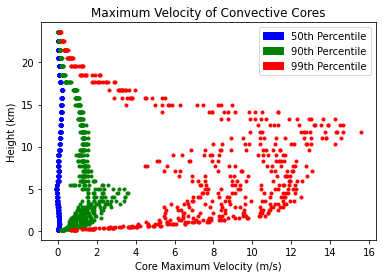

In [ ]:
for t in range(12):
    plt.scatter(ws_vel_max_50[t], height, marker='.', color ='b')
for t in range(12):
  plt.scatter(ws_vel_max_90[t], height, marker='.', color ='g')
for t in range(12):
  plt.scatter(ws_vel_max_99[t], height, marker='.', color ='r')
plt.title("Maximum Velocity of Convective Cores")
plt.ylabel("Height (km)")
plt.xlabel('Core Maximum Velocity (m/s)')
fifty_color = mpatches.Patch(color = 'b', label = '50th Percentile')
ninety_color = mpatches.Patch(color = 'g', label = '90th Percentile')
ninetynine_color = mpatches.Patch(color = 'r', label = '99th Percentile')
plt.legend(handles = [fifty_color, ninety_color,ninetynine_color])
plt.show()

The graph shows that as the height increases, the core maximum velocity begins to steadily increase and then steadily decrease once the max height is reached. The maximum velocity appears to peak around a height of 12 or 13 km for the 99th percentile. For the 90th percentile, the velcoties share a similar trend of progression, but the peak of the maximum velocities is around 4 km. For the 50th percentile, the maximum velocity for each height appears to be very consistent across all heights.

The scatterplot for Average Velocity of Convective Cores is graphed and shown below. 

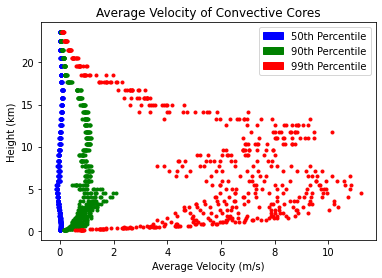

In [ ]:
for t in range(12):
    plt.scatter(ws_vel_avg_50[t], height, marker='.', color ='b')
for t in range(12):
  plt.scatter(ws_vel_avg_90[t], height, marker='.', color ='g')
for t in range(12):
  plt.scatter(ws_vel_avg_99[t], height, marker='.', color ='r')
plt.title("Average Velocity of Convective Cores")
plt.ylabel("Height (km)")
plt.xlabel('Average Velocity (m/s)')
fifty_color = mpatches.Patch(color = 'b', label = '50th Percentile')
ninety_color = mpatches.Patch(color = 'g', label = '90th Percentile')
ninetynine_color = mpatches.Patch(color = 'r', label = '99th Percentile')
plt.legend(handles = [fifty_color, ninety_color,ninetynine_color])
plt.show()

The graph shows that as the height increases, the core average velocity begins to steadily increase, suddenly decrease, increase slightly, and then steadily decrease once the max height is reached. The maximum velocity appears to peak around a height of 5 km for the 99th percentile. For the 90th percentile, the velcoties share a similar trend of progression, but the increases and decreases are much less defined. The peak of the maximum velocities is around 4 km. For the 50th percentile, the average velocity for each height appears to be very consistent across all heights.

The scatterplot for Size of Convective Cores is graphed and shown below. 

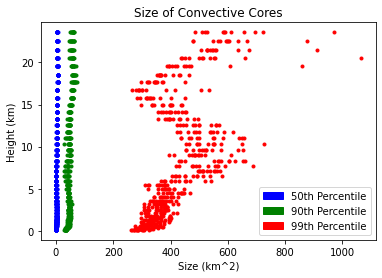

In [ ]:
for t in range(12):
    plt.scatter(ws_size_50[t], height, marker='.', color ='b')
for t in range(12):
  plt.scatter(ws_size_90[t], height, marker='.', color ='g')
for t in range(12):
  plt.scatter(ws_size_99[t], height, marker='.', color ='r')
plt.title("Size of Convective Cores")
plt.ylabel("Height (km)")
plt.xlabel('Size (km^2)')
fifty_color = mpatches.Patch(color = 'b', label = '50th Percentile')
ninety_color = mpatches.Patch(color = 'g', label = '90th Percentile')
ninetynine_color = mpatches.Patch(color = 'r', label = '99th Percentile')
plt.legend(handles = [fifty_color, ninety_color,ninetynine_color])
plt.show()

For the 99th percentile, the progression of the graph shows a slight increase, then a sudden decrease, and increasing again once the max height is approached. The maximum size appears to peak around 20 to 23 km. Both the 50th and 90th percentiles show a similar trend of rare increases as height increases, although the 90th percentile values are slightly larger.

#Conclusions


**Results**

The shapes of the maximum and average velocities in both Objectives 1 and 2 share similar shapes, but the distribution of the percentiles vary for both objectives. In objective 1, the percentile data seems to overlap each other quite a lot. In objective 2, the percentile data appears more separated and distinct from each percentile. The differences in the ranges for the x-axis values in the average and maximum velocity graphs in both objectives are very small. For the size graphs, the approach to calculating the statistic varied, so the units and the values for each objective differ. In objective 1, the units are measured in km, while in objective 2 the units are measured in km^2. The distribution of the percentiles for the size graphs share a similar trend to those of the maximum and average velocity graphs. In the size graph for objective 2, the percentiles are more spread out, while in objective 1 the percentiles overlap each other.
Some of the similarities and differences between objectives 1 and 2 may have stemmed from the watershedding algorithm. In many cases, the watershedding algorithm most likely heavily manipulated the data, causing a major difference in some of our data. But it is possible that in certain scenarios the watershedding algorithnm did not have much effect on the data, leading to similarities between both objectives.

When comparing the graphs from objective 1 to those from Khairoutdinov,. et. al, the shapes of our graphs were similar, while the spread of the percentiles varied. In the original graphs, the percentile data showed a distinct separation for each percentile, while our percentile data appears to overlap each other. Our size graph does not show a similar shape to the original graph, but shares a similarity in the spread of ther percentile distributions.
When comparing the graphs from objective 2 to the original graphs, both the shape and the spread of the percentile data are somewhat similar. Although the graphs from Khairoutdinov,. et. al show separation for the percentiles, there is still some overlapping data, while our graphs show almost no overlappping percentile data. Since our size graph is measured in km^2, its shape and distribution varies greatly to that of the original graph. However, the shape of our 99th percentile for size does show similarities to the shape in the original graph.

**Future Research Possibilities**

Studies could be performed on the downdrafts from the dataset so that they might be compared to our values for updrafts. If we adjust our approach for calculating size in objective 2, we could more easily compare the graphs for size. 

**Progress**

Objective 1

Instead of iterating through the widths at each height, we used the ```notmaskedcontiguous()``` function in order to get slices which we iterated through in order to calculate all of the values used to aquire percentiles for the plots. We modified our for loops so that they iterated through an integer index instead of the dimensions of the original 4d array.

Objective 2

Instead of performing the watershedding algorithm on the entire 4D dataset, we put the algorithm inside the nested loops to properly perform watershedding. Then using a loop for the range of the max of the segmented labels, we were able to properly calculate the statistics of each core. However, we do not think the approach we took for the size variable is fully correct yet,



**Questions**

Who might find these products useful to their mission?

Might there be a benefit to using watershedded vs. non-watershedded data?

Might there be a stronger or more efficient coding language or set of methods to be used in this research?

Is calculating values over slices the best way to represent the data?

#Bibliography
Khairoutdinov, M. F., Krueger, S. K., Moeng, C. H., Bogenschutz, P. A., & Randall, D. A. (2009). Large‐eddy simulation of maritime deep tropical convection. Journal of Advances in Modeling Earth Systems, 1(4).

Tao, W-K., et al. "Microphysics, radiation and surface processes in the Goddard Cumulus Ensemble (GCE) model." Meteorology & Atmospheric Physics 82 (2003).